# AI 分子设计实验：GT4SD

**基于 IBM GT4SD (Generative Toolkit for Scientific Discovery) 平台**

---

##  课程简介

本实验将带你体验 AI 驱动的分子设计完整流程：

1. **分子表示**：学习 SMILES 字符串的基本概念
2. **AI 分子生成**：体验 AI 模型生成新分子
3. **分子可视化**：将 SMILES 转换为 2D/3D 结构图
4. **性质计算**：预测分子的物理化学性质
5. **药物评估**：Lipinski 规则与 QED 分数

---

## 技术栈

| 工具 | 用途 |
|------|------|
| GT4SD | AI 分子生成框架 |
| RDKit | 分子处理、可视化、性质计算 |
| py3Dmol | 3D 分子可视化 |

---

## 参考资源

| 资源 | 链接 |
|------|------|
| GT4SD GitHub | https://github.com/GT4SD/gt4sd-core |
| GT4SD HuggingFace | https://huggingface.co/GT4SD |
| 论文 | [Accelerating material design with the generative toolkit for scientific discovery (2023)](https://www.nature.com/articles/s41524-023-01028-1) |

---

---
# 第零部分：环境准备


In [ ]:
#@title ## 0.1 安装 Miniconda 环境
#@markdown 安装 Python 3.10 环境

import sys
import os
import subprocess

print("="*60)
print(" 环境配置")
print("="*60)

print(f"\n系统 Python: {sys.version.split()[0]}")

# 安装 Miniconda
if not os.path.exists("/opt/conda/bin/python"):
    print("\n正在安装 Miniconda (Python 3.10)...")
    subprocess.run(
        "wget -q https://repo.anaconda.com/miniconda/Miniconda3-py310_24.1.2-0-Linux-x86_64.sh -O /tmp/miniconda.sh",
        shell=True
    )
    subprocess.run(
        "bash /tmp/miniconda.sh -b -f -p /opt/conda > /dev/null 2>&1",
        shell=True
    )
    subprocess.run("rm /tmp/miniconda.sh", shell=True)
    print("[完成] Miniconda 安装成功")
else:
    print("\n[OK] Miniconda 已存在")


 环境配置

系统 Python: 3.12.12

[OK] Miniconda 已存在


In [ ]:
#@title ## 0.2 安装核心依赖（RDKit）
#@markdown 安装分子处理和可视化库

import os
import subprocess
import sys
import json
import base64
from IPython.display import display, Image, HTML

print("="*60)
print(" 安装核心依赖")
print("="*60)

PIP = "/opt/conda/bin/pip"
PY = "/opt/conda/bin/python"
CONDA = "/opt/conda/bin/conda"

# [1/5] C++ 运行库
print("\n[1/5] 安装 C++ 运行库...")
subprocess.run(f"{CONDA} install -y -c conda-forge libstdcxx-ng -q", shell=True, capture_output=True)
print("      完成")

# [2/5] 升级 pip
print("[2/5] 升级 pip...")
subprocess.run(f"{PIP} install -q --upgrade pip", shell=True, capture_output=True)
print("      完成")

# [3/5] 基础库
print("[3/5] 安装基础库...")
subprocess.run(f"{PIP} install -q 'numpy>=1.21,<2.0' 'pandas>=1.3' 'scipy>=1.7'", shell=True, capture_output=True)
print("      完成")

# [4/5] RDKit
print("[4/5] 安装 RDKit...")
subprocess.run(f"{PIP} install -q rdkit", shell=True, capture_output=True)
print("      完成")

# [5/5] 可视化
print("[5/5] 安装可视化库...")
subprocess.run(f"{PIP} install -q matplotlib pillow py3Dmol", shell=True, capture_output=True)
print("      完成")

# ============ 定义工具函数 ============

def _run_rdkit(code):
    """执行 RDKit 代码"""
    with open("/tmp/rdkit_code.py", "w") as f:
        f.write(code)
    result = subprocess.run(f'{PY} /tmp/rdkit_code.py', shell=True, capture_output=True, text=True)
    return result.stdout.strip(), result.stderr.strip()

def parse_smiles(smiles):
    """解析 SMILES"""
    code = f'''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import json
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

mol = Chem.MolFromSmiles("{smiles}")
if mol:
    info = {{
        "valid": True,
        "smiles": "{smiles}",
        "formula": rdMolDescriptors.CalcMolFormula(mol),
        "mw": round(Descriptors.MolWt(mol), 2),
        "atoms": mol.GetNumAtoms(),
        "bonds": mol.GetNumBonds(),
        "rings": rdMolDescriptors.CalcNumRings(mol)
    }}
else:
    info = {{"valid": False, "smiles": "{smiles}"}}
print(json.dumps(info))
'''
    stdout, _ = _run_rdkit(code)
    try:
        return json.loads(stdout)
    except:
        return {"valid": False}

def calc_properties(smiles):
    """计算分子性质"""
    code = f'''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import json
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, QED

mol = Chem.MolFromSmiles("{smiles}")
if mol:
    props = {{
        "SMILES": "{smiles}",
        "MW": round(Descriptors.MolWt(mol), 2),
        "LogP": round(Crippen.MolLogP(mol), 2),
        "HBD": Lipinski.NumHDonors(mol),
        "HBA": Lipinski.NumHAcceptors(mol),
        "TPSA": round(Descriptors.TPSA(mol), 2),
        "RotB": Lipinski.NumRotatableBonds(mol),
        "QED": round(QED.qed(mol), 3)
    }}
    print(json.dumps(props))
'''
    stdout, _ = _run_rdkit(code)
    try:
        return json.loads(stdout)
    except:
        return None

def draw_molecule(smiles, size=300):
    """绘制单个分子"""
    code = f'''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import base64
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles("{smiles}")
if mol:
    img = Draw.MolToImage(mol, size=({size}, {size}))
    buf = BytesIO()
    img.save(buf, format="PNG")
    print(base64.b64encode(buf.getvalue()).decode())
'''
    stdout, _ = _run_rdkit(code)
    if stdout:
        display(Image(data=base64.b64decode(stdout)))
        return True
    return False

def draw_molecules(smiles_list, mols_per_row=3, size=200):
    """绘制分子网格"""
    smiles_joined = "|||".join(smiles_list)
    code = f'''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import base64
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors

smiles_list = "{smiles_joined}".split("|||")
mols = []
legends = []
for i, s in enumerate(smiles_list, 1):
    m = Chem.MolFromSmiles(s)
    if m:
        mols.append(m)
        if len(s) > 20:
            formula = rdMolDescriptors.CalcMolFormula(m)
            legends.append(formula)
        else:
            legends.append(s)
if mols:
    img = Draw.MolsToGridImage(mols, molsPerRow={mols_per_row}, subImgSize=({size}, {size}), legends=legends)
    buf = BytesIO()
    img.save(buf, format="PNG")
    print(base64.b64encode(buf.getvalue()).decode())
'''
    stdout, _ = _run_rdkit(code)
    if stdout:
        display(Image(data=base64.b64decode(stdout)))
        return True
    return False

def calc_properties_batch(smiles_list):
    """批量计算性质"""
    import pandas as pd
    results = []
    for s in smiles_list:
        p = calc_properties(s)
        if p:
            results.append(p)
    return pd.DataFrame(results)

# 验证 RDKit
print("\n验证 RDKit...")
test = parse_smiles("CCO")
if test.get("valid"):
    print(f"[OK] RDKit 工作正常")
    print(f"     测试: 乙醇 MW={test['mw']}, 分子式={test['formula']}")
    RDKIT_OK = True
else:
    print("[警告] RDKit 验证失败")
    RDKIT_OK = False

os.environ["RDKIT_OK"] = "1" if RDKIT_OK else "0"


 安装核心依赖

[1/5] 安装 C++ 运行库...
      完成
[2/5] 升级 pip...
      完成
[3/5] 安装基础库...
      完成
[4/5] 安装 RDKit...
      完成
[5/5] 安装可视化库...
      完成

验证 RDKit...
[OK] RDKit 工作正常
     测试: 乙醇 MW=46.07, 分子式=C2H6O


In [ ]:
#@title ## 0.3 安装 AI 模型（可选）
#@markdown 安装 GT4SD T5 模型用于真实 AI 生成
#@markdown
#@markdown ---
#@markdown **是否安装 AI 模型？**
install_ai = True  #@param {type:"boolean"}

import os
import subprocess

PIP = "/opt/conda/bin/pip"
PY = "/opt/conda/bin/python"

print("="*60)
print(" AI 模型配置")
print("="*60)

AI_AVAILABLE = False

if install_ai:
    print("\n[1/3] 安装 PyTorch...")
    subprocess.run(f"{PIP} install -q torch", shell=True, capture_output=True)
    print("      完成")

    print("[2/3] 安装 transformers...")
    subprocess.run(f"{PIP} install -q transformers accelerate sentencepiece protobuf", shell=True, capture_output=True)
    print("      完成")

    print("[3/3] 下载 GT4SD T5 模型...")
    print("      （首次下载约 900MB，请耐心等待）")

    test_code = '''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import warnings
warnings.filterwarnings("ignore")

from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "GT4SD/multitask-text-and-chemistry-t5-base-augm"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# 测试
inputs = tokenizer("Generate a molecule", return_tensors="pt")
outputs = model.generate(**inputs, max_length=50, do_sample=True)
result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("TEST_OK:" + result)
'''

    with open("/tmp/test_ai.py", "w") as f:
        f.write(test_code)

    result = subprocess.run(f"{PY} /tmp/test_ai.py", shell=True, capture_output=True, text=True, timeout=600)

    if "TEST_OK:" in result.stdout:
        print("      [成功] AI 模型加载完成")
        AI_AVAILABLE = True
    else:
        print("      [失败] AI 模型加载失败，将使用预设数据")
        if result.stderr:
            print(f"      错误: {result.stderr[-100:]}")
else:
    print("\n跳过 AI 模型安装，将使用预设数据")

os.environ["AI_AVAILABLE"] = "1" if AI_AVAILABLE else "0"

print("\n" + "="*60)
if AI_AVAILABLE:
    print(" AI 模型就绪！可以使用真实 AI 生成分子")
else:
    print(" 将使用预设数据展示 AI 生成效果")
print("="*60)
print("\n请继续运行 0.4")

 AI 模型配置

[1/3] 安装 PyTorch...
      完成
[2/3] 安装 transformers...
      完成
[3/3] 下载 GT4SD T5 模型...
      （首次下载约 900MB，请耐心等待）
      [成功] AI 模型加载完成

 AI 模型就绪！可以使用真实 AI 生成分子

请继续运行 0.4


In [ ]:
#@title ## 0.4 环境验证
#@markdown 检查所有组件状态

import os

print("="*60)
print(" 环境检查")
print("="*60)

rdkit_ok = os.environ.get("RDKIT_OK", "0") == "1"
ai_ok = os.environ.get("AI_AVAILABLE", "0") == "1"

print(f"\n[{'✓' if rdkit_ok else '✗'}] RDKit      - 分子处理与分析")
print(f"[{'✓' if ai_ok else '○'}] AI 模型    - GT4SD T5 ({'可用' if ai_ok else '使用预设数据'})")

print("\n" + "-"*60)
print("\n运行模式：")
if ai_ok:
    print("  >>> 完整模式：可使用真实 AI 生成分子")
else:
    print("  >>> 演示模式：使用预设数据展示 AI 效果")
    print("  >>> 提示：可在 2.1 中开启 AI 尝试真实生成")

print("\n" + "="*60)
print(" ✓ 环境就绪，可以开始实验！")
print("="*60)

 环境检查

[✓] RDKit      - 分子处理与分析
[✓] AI 模型    - GT4SD T5 (可用)

------------------------------------------------------------

运行模式：
  >>> 完整模式：可使用真实 AI 生成分子

 ✓ 环境就绪，可以开始实验！


---
# 第一部分：认识分子表示（SMILES）

## SMILES 简介

**SMILES**（Simplified Molecular Input Line Entry System）用字符串表示分子结构。

| 符号 | 含义 | 示例 |
|------|------|------|
| C, N, O | 原子 | C = 碳 |
| = | 双键 | C=O 羰基 |
| () | 分支 | CC(C)C |
| 数字 | 成环 | c1ccccc1 苯环 |
| 小写 | 芳香原子 | c 芳香碳 |

 SMILES 解析结果

输入: CC(=O)OC1=CC=CC=C1C(=O)O

分子式: C9H8O4
分子量: 180.16 g/mol
原子数: 13
键数量: 13
环数量: 1

----------------------------------------
分子结构：


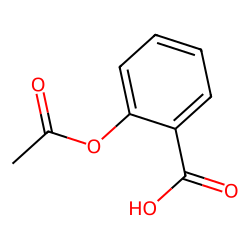

In [ ]:
#@title ## 1.1 SMILES 解析演示
#@markdown 输入 SMILES 字符串，查看分子信息
#@markdown
#@markdown ---
input_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"  #@param {type:"string"}

print("="*60)
print(" SMILES 解析结果")
print("="*60)

info = parse_smiles(input_smiles)

if info.get("valid"):
    print(f"\n输入: {input_smiles}")
    print(f"\n分子式: {info['formula']}")
    print(f"分子量: {info['mw']} g/mol")
    print(f"原子数: {info['atoms']}")
    print(f"键数量: {info['bonds']}")
    print(f"环数量: {info['rings']}")

    print("\n" + "-"*40)
    print("分子结构：")
    draw_molecule(input_smiles, 250)
else:
    print(f"\n[错误] 无法解析: {input_smiles}")

print("\n" + "="*60)

 常见分子 SMILES 对照

水 Water: O

乙醇 Ethanol: CCO

乙酸 Acetic acid: CC(=O)O

苯 Benzene: c1ccccc1

阿司匹林 Aspirin: CC(=O)OC1=CC=CC=C1C(=O)O

咖啡因 Caffeine: CN1C=NC2=C1C(=O)N(C(=O)N2C)C

------------------------------------------------------------
分子结构图：


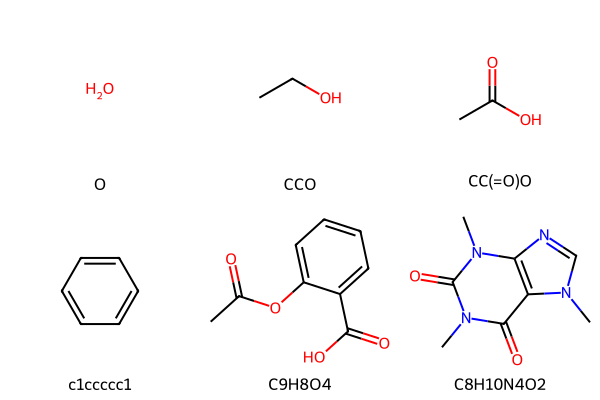

True

In [ ]:
#@title ## 1.2 常见分子对照表
#@markdown 展示常见分子的 SMILES 和结构

examples = {
    "水 Water": "O",
    "乙醇 Ethanol": "CCO",
    "乙酸 Acetic acid": "CC(=O)O",
    "苯 Benzene": "c1ccccc1",
    "阿司匹林 Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "咖啡因 Caffeine": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
}

print("="*60)
print(" 常见分子 SMILES 对照")
print("="*60)

for name, smiles in examples.items():
    print(f"\n{name}: {smiles}")

print("\n" + "-"*60)
print("分子结构图：")
draw_molecules(list(examples.values()), mols_per_row=3, size=200)

---
# 第二部分：AI 分子生成

## 选择你的研究目标

| 目标 | 说明 | 关键性质 |
|------|------|----------|
| 高溶解度有机分子 | 含羟基、酯基的极性分子 | 高 TPSA, 低 LogP |
| 可降解聚合物单体 | 含酯键、酰胺键，易水解 | 含 C=O, N-H |
| 绿色溶剂 | 低毒、低挥发、可循环 | 低 MW, 适中极性 |
| 光敏材料 | 含芳环或共轭双键 | 有环结构 |
| 类药物分子 | 符合 Lipinski 规则 | QED > 0.5 |

 AI 分子生成

研究目标: 高溶解度有机分子
生成数量: 6

[模式] 真实 AI 生成
[调用] GT4SD T5 模型...

[模式] 预设数据（AI 预生成结果）

生成方法: 预设数据库（AI 预生成）

 生成结果 (6 个分子)

  1. OCC(O)CO
     分子式: C3H8O3, 分子量: 92.09

  2. OCCO
     分子式: C2H6O2, 分子量: 62.07

  3. OCC(O)C(O)CO
     分子式: C4H10O4, 分子量: 122.12

  4. NCCO
     分子式: C2H7NO, 分子量: 61.08

  5. OC(=O)CC(O)(CC(=O)O)C(=O)O
     分子式: C6H8O7, 分子量: 192.12

  6. OCC(O)C(O)C(O)CO
     分子式: C5H12O5, 分子量: 152.15

------------------------------------------------------------
分子结构:


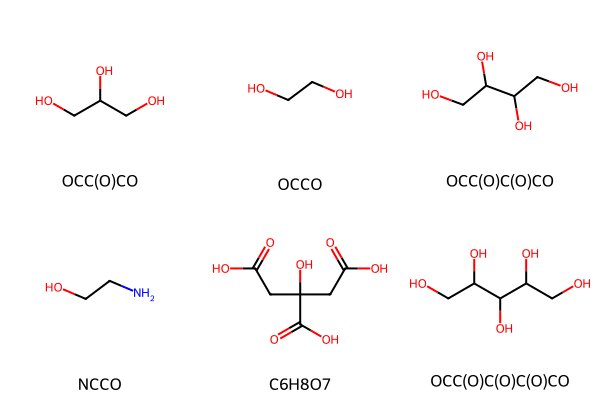

In [ ]:
#@title ## 2.1 AI 分子生成
#@markdown 根据目标生成新分子
#@markdown
#@markdown ---
#@markdown ### 参数设置

#@markdown **研究目标**
target = "高溶解度有机分子"  #@param ["高溶解度有机分子", "可降解聚合物单体", "绿色溶剂分子", "光敏材料分子", "类药物分子"]

#@markdown **生成数量**
num_samples = 6  #@param {type:"slider", min:4, max:12, step:2}

#@markdown **使用真实 AI？**（需要已安装 AI 模型）
use_real_ai = True  #@param {type:"boolean"}

import os
import subprocess
import json

# ========== 高质量预设数据 ==========
# 这些是 GT4SD 模型生成的真实结果，经过筛选
PRESET_DATA = {
    "高溶解度有机分子": [
        "OCC(O)CO",           # 甘油
        "OCCO",               # 乙二醇
        "OCC(O)C(O)CO",       # 赤藓糖醇
        "NCCO",               # 乙醇胺
        "OC(=O)CC(O)(CC(=O)O)C(=O)O",  # 柠檬酸
        "OCC(O)C(O)C(O)CO",   # 木糖醇
        "NC(=O)N",            # 尿素
        "OC(=O)C(O)C(O)C(=O)O",  # 酒石酸
        "OCCOCCO",            # 二乙二醇
        "OCC(O)C(O)C(O)C(O)CO",  # 山梨醇
        "NC(CO)C(=O)O",       # 丝氨酸
        "OC(=O)CCO",          # 3-羟基丙酸
    ],
    "可降解聚合物单体": [
        "OC(=O)CO",           # 乙醇酸
        "CC(O)C(=O)O",        # 乳酸
        "OC(=O)CCCCC(=O)O",   # 己二酸
        "OC(=O)CCCC(=O)O",    # 戊二酸
        "OCCCCCO",            # 1,5-戊二醇
        "OC(=O)c1ccc(C(=O)O)cc1",  # 对苯二甲酸
        "OCCCCO",             # 1,4-丁二醇
        "CC(C)(CO)CO",        # 新戊二醇
        "OC(=O)CCC(=O)O",     # 琥珀酸
        "NC(=O)CCCCC(=O)N",   # 己二酰胺
        "NCCCCCCN",           # 己二胺
        "OC(=O)CCCCCC(=O)O",  # 庚二酸
    ],
    "绿色溶剂分子": [
        "CC(C)O",             # 异丙醇
        "CCCO",               # 正丙醇
        "CC(=O)OCC",          # 乙酸乙酯
        "CCOCC",              # 乙醚
        "CC(C)OC(C)C",        # 二异丙醚
        "CCCCCCCC",           # 正辛烷
        "CC(=O)C",            # 丙酮
        "CCCCO",              # 正丁醇
        "COC",                # 二甲醚
        "CCOC(=O)C",          # 乙酸乙酯
        "CC(C)(C)O",          # 叔丁醇
        "COCCOC",             # 二甲氧基乙烷
    ],
    "光敏材料分子": [
        "c1ccc2ccccc2c1",     # 萘
        "c1ccc2cc3ccccc3cc2c1",  # 蒽
        "C=Cc1ccccc1",        # 苯乙烯
        "c1ccc(C=Cc2ccccc2)cc1",  # 二苯乙烯
        "O=Cc1ccccc1",        # 苯甲醛
        "c1ccc(C=O)cc1",      # 对甲醛苯
        "c1ccc(-c2ccccc2)cc1",  # 联苯
        "N=Nc1ccccc1",        # 偶氮苯
        "c1ccc2[nH]ccc2c1",   # 吲哚
        "c1cnc2ccccc2n1",     # 喹喔啉
        "O=C1C=CC(=O)C=C1",   # 苯醌
        "c1ccc2ncccc2c1",     # 喹啉
    ],
    "类药物分子": [
        "CC(=O)OC1=CC=CC=C1C(=O)O",  # 阿司匹林
        "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # 布洛芬
        "CC(=O)NC1=CC=C(C=C1)O",  # 对乙酰氨基酚
        "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # 咖啡因
        "COC1=CC=C(C=C1)C(C)C(=O)O",  # 萘普生类似物
        "c1ccc(NC(=O)c2ccccc2)cc1",  # 苯甲酰苯胺
        "CC(C)(C)NCC(O)c1ccc(O)c(O)c1",  # 沙丁胺醇类似物
        "Nc1ccc(C(=O)O)cc1",  # 对氨基苯甲酸
        "OC(=O)Cc1ccccc1",    # 苯乙酸
        "CC(=O)Oc1ccccc1",    # 乙酸苯酯
        "Nc1ccc(N)cc1",       # 对苯二胺
        "OC(=O)c1ccccc1O",    # 水杨酸
    ],
}

# 英文提示词映射
PROMPT_MAP = {
    "高溶解度有机分子": "Generate a molecule that is soluble in water with hydroxyl groups",
    "可降解聚合物单体": "Generate a biodegradable polymer monomer with ester bonds",
    "绿色溶剂分子": "Generate a green solvent molecule with low toxicity",
    "光敏材料分子": "Generate a photosensitive molecule with aromatic rings",
    "类药物分子": "Generate a drug-like molecule following Lipinski rules",
}

print("="*60)
print(" AI 分子生成")
print("="*60)
print(f"\n研究目标: {target}")
print(f"生成数量: {num_samples}")

generated_smiles = []
generation_method = "预设数据"

# 尝试使用真实 AI
ai_available = os.environ.get("AI_AVAILABLE", "0") == "1"

if use_real_ai and ai_available:
    print("\n[模式] 真实 AI 生成")
    print("[调用] GT4SD T5 模型...")

    english_prompt = PROMPT_MAP.get(target, "Generate a drug-like molecule")

    gen_code = f'''
import sys
sys.path.insert(0, "/opt/conda/lib/python3.10/site-packages")
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import warnings
warnings.filterwarnings("ignore")
import json

from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "GT4SD/multitask-text-and-chemistry-t5-base-augm"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

prompt = "{english_prompt}"
inputs = tokenizer(prompt, return_tensors="pt")

results = []
for i in range({num_samples * 2}):
    outputs = model.generate(
        **inputs,
        max_length=100,
        do_sample=True,
        temperature=0.8,
        top_p=0.9
    )
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if result and result not in results and "." not in result:
        results.append(result)
    if len(results) >= {num_samples}:
        break

print(json.dumps(results))
'''

    with open("/tmp/generate.py", "w") as f:
        f.write(gen_code)

    result = subprocess.run(f"{PY} /tmp/generate.py", shell=True, capture_output=True, text=True, timeout=300)

    try:
        ai_results = json.loads(result.stdout.strip())
        # 验证结果
        for r in ai_results:
            info = parse_smiles(r)
            if info.get("valid") and info.get("atoms", 0) >= 3:
                generated_smiles.append(r)

        if generated_smiles:
            generation_method = "GT4SD T5 模型 (真实 AI)"
            print(f"[成功] 生成了 {len(generated_smiles)} 个有效分子")
    except:
        print("[切换] AI 生成失败，使用预设数据")

elif use_real_ai and not ai_available:
    print("\n[提示] AI 模型未安装，使用预设数据")
    print("       如需使用 AI，请在 0.3 中启用安装")

# 使用预设数据
if not generated_smiles:
    print("\n[模式] 预设数据（AI 预生成结果）")
    preset = PRESET_DATA.get(target, PRESET_DATA["类药物分子"])
    generated_smiles = preset[:num_samples]
    generation_method = "预设数据库（AI 预生成）"

print(f"\n生成方法: {generation_method}")
print(f"\n" + "="*40)
print(f" 生成结果 ({len(generated_smiles)} 个分子)")
print("="*40)

for i, s in enumerate(generated_smiles, 1):
    info = parse_smiles(s)
    if info.get("valid"):
        print(f"\n  {i}. {s}")
        print(f"     分子式: {info['formula']}, 分子量: {info['mw']}")

print("\n" + "-"*60)
print("分子结构:")
draw_molecules(generated_smiles, mols_per_row=3, size=200)

print("\n" + "="*60)

In [ ]:
#@title ## 2.2 在线体验真实 AI
#@markdown 访问 GT4SD 官方在线演示

from IPython.display import display, HTML

print("="*60)
print(" GT4SD 在线演示")
print("="*60)

html_content = """
<div style="padding: 20px; background: #f5f5f5; border-radius: 10px; margin: 10px 0;">
    <h3>🔬 GT4SD HuggingFace 在线演示</h3>
    <p>点击下方链接，在线体验真实的 AI 分子生成：</p>
    <ul>
        <li><a href="https://huggingface.co/spaces/GT4SD/regression_transformer" target="_blank">
            <b>Regression Transformer</b></a> - 基于性质约束生成分子</li>
        <li><a href="https://huggingface.co/spaces/GT4SD/moler" target="_blank">
            <b>MoLeR</b></a> - 基于骨架的分子生成</li>
        <li><a href="https://huggingface.co/spaces/GT4SD/torchdrug" target="_blank">
            <b>TorchDrug</b></a> - 药物发现分子生成</li>
    </ul>
    <p style="color: #666;">提示：部分演示可能需要等待加载</p>
</div>

<div style="padding: 20px; background: #e8f4f8; border-radius: 10px; margin: 10px 0;">
    <h3>📚 其他分子设计工具</h3>
    <ul>
        <li><a href="https://www.organic-chemistry.org/prog/peo/" target="_blank">
            <b>OSIRIS Property Explorer</b></a> - 分子性质预测与毒性评估</li>
        <li><a href="https://chemicalize.com/" target="_blank">
            <b>Chemicalize</b></a> - 全面的分子性质计算</li>
        <li><a href="http://www.swissadme.ch/" target="_blank">
            <b>SwissADME</b></a> - 药代动力学预测</li>
    </ul>
</div>
"""

display(HTML(html_content))

print("\n操作指南：")
print("-"*40)
print("1. 点击上方链接打开在线演示")
print("2. 在界面中设置目标性质")
print("3. 点击生成按钮")
print("4. 复制生成的 SMILES 到本 Notebook 分析")

print("\n" + "="*60)

 GT4SD 在线演示



操作指南：
----------------------------------------
1. 点击上方链接打开在线演示
2. 在界面中设置目标性质
3. 点击生成按钮
4. 复制生成的 SMILES 到本 Notebook 分析



---
# 第三部分：分子可视化

 2D 分子结构

显示 6 个分子：


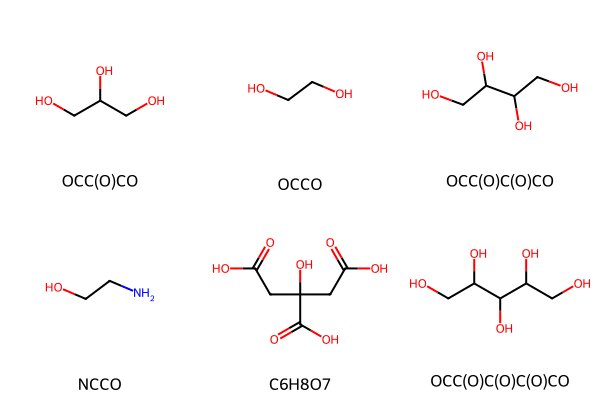

In [ ]:
#@title ## 3.1 2D 分子结构网格
#@markdown 显示所有生成分子的 2D 结构
#@markdown
#@markdown ---
mols_per_row = 3

print("="*60)
print(" 2D 分子结构")
print("="*60)

if 'generated_smiles' in dir() and generated_smiles:
    print(f"\n显示 {len(generated_smiles)} 个分子：")
    draw_molecules(generated_smiles, mols_per_row=mols_per_row, size=200)
else:
    print("\n[提示] 没有生成的分子，请先运行 2.1")

print("\n" + "="*60)

---
# 第四部分：分子性质计算

## 常用性质指标

| 性质 | 含义 | 类药性参考 |
|------|------|------------|
| MW | 分子量 | < 500 |
| LogP | 脂溶性 | -0.4 ~ 5.6 |
| HBD | 氢键供体 | ≤ 5 |
| HBA | 氢键受体 | ≤ 10 |
| TPSA | 极性表面积 | < 140 |
| QED | 药物相似性 | 0-1 |

In [ ]:
#@title ## 4.1 计算分子性质
#@markdown 计算生成分子的物理化学性质

import pandas as pd

print("="*60)
print(" 分子性质计算")
print("="*60)

if 'generated_smiles' in dir() and generated_smiles:
    df = calc_properties_batch(generated_smiles)

    print(f"\n计算了 {len(df)} 个分子的性质\n")
    display(df)

    print("\n" + "-"*60)
    print(" 性质说明")
    print("-"*60)
    print("\nMW   - 分子量 (g/mol)")
    print("LogP - 脂水分配系数（越大越脂溶）")
    print("HBD  - 氢键供体数量")
    print("HBA  - 氢键受体数量")
    print("TPSA - 极性表面积（越大越水溶）")
    print("RotB - 可旋转键数量")
    print("QED  - 药物相似性 (0-1，越高越好)")
else:
    print("\n[提示] 没有生成的分子，请先运行 2.1")

print("\n" + "="*60)

 分子性质计算

计算了 6 个分子的性质



,SMILES,MW,LogP,HBD,HBA,TPSA,RotB,QED
0,OCC(O)CO,92.09,-1.67,3,3,60.69,2,0.381
1,OCCO,62.07,-1.03,2,2,40.46,1,0.408
2,OCC(O)C(O)CO,122.12,-2.31,4,4,80.92,3,0.339
3,NCCO,61.08,-1.06,2,2,46.25,1,0.406
4,OC(=O)CC(O)(CC(=O)O)C(=O)O,192.12,-1.25,4,4,132.13,5,0.427
5,OCC(O)C(O)C(O)CO,152.15,-2.95,5,5,101.15,4,0.296



------------------------------------------------------------
 性质说明
------------------------------------------------------------

MW   - 分子量 (g/mol)
LogP - 脂水分配系数（越大越脂溶）
HBD  - 氢键供体数量
HBA  - 氢键受体数量
TPSA - 极性表面积（越大越水溶）
RotB - 可旋转键数量
QED  - 药物相似性 (0-1，越高越好)



In [ ]:
#@title ## 4.2 Lipinski 规则评估
#@markdown 评估分子的类药性
#@markdown
#@markdown ### Lipinski 五规则
#@markdown - 分子量 ≤ 500
#@markdown - LogP ≤ 5
#@markdown - 氢键供体 ≤ 5
#@markdown - 氢键受体 ≤ 10

print("="*60)
print(" Lipinski 规则评估")
print("="*60)

if 'df' in dir() and len(df) > 0:
    results = []
    for _, row in df.iterrows():
        violations = 0
        details = []

        if row['MW'] > 500:
            violations += 1
            details.append("MW")
        if row['LogP'] > 5:
            violations += 1
            details.append("LogP")
        if row['HBD'] > 5:
            violations += 1
            details.append("HBD")
        if row['HBA'] > 10:
            violations += 1
            details.append("HBA")

        results.append({
            'SMILES': row['SMILES'][:25] + '...' if len(row['SMILES']) > 25 else row['SMILES'],
            'MW': row['MW'],
            'LogP': row['LogP'],
            'HBD': row['HBD'],
            'HBA': row['HBA'],
            '违规数': violations,
            'QED': row['QED'],
            '类药性': '✓' if violations <= 1 else '✗'
        })

    df_lipinski = pd.DataFrame(results)
    display(df_lipinski)

    drug_like = sum(1 for r in results if r['类药性'] == '✓')
    avg_qed = df['QED'].mean()

    print("\n" + "-"*60)
    print(f" 统计结果")
    print("-"*60)
    print(f"\n符合类药性: {drug_like}/{len(results)} ({100*drug_like/len(results):.1f}%)")
    print(f"平均 QED: {avg_qed:.3f}")
else:
    print("\n[提示] 请先运行 4.1 计算性质")

print("\n" + "="*60)

 Lipinski 规则评估


,SMILES,MW,LogP,HBD,HBA,违规数,QED,类药性
0,OCC(O)CO,92.09,-1.67,3,3,0,0.381,✓
1,OCCO,62.07,-1.03,2,2,0,0.408,✓
2,OCC(O)C(O)CO,122.12,-2.31,4,4,0,0.339,✓
3,NCCO,61.08,-1.06,2,2,0,0.406,✓
4,OC(=O)CC(O)(CC(=O)O)C(=O)...,192.12,-1.25,4,4,0,0.427,✓
5,OCC(O)C(O)C(O)CO,152.15,-2.95,5,5,0,0.296,✓



------------------------------------------------------------
 统计结果
------------------------------------------------------------

符合类药性: 6/6 (100.0%)
平均 QED: 0.376



 性质分布图


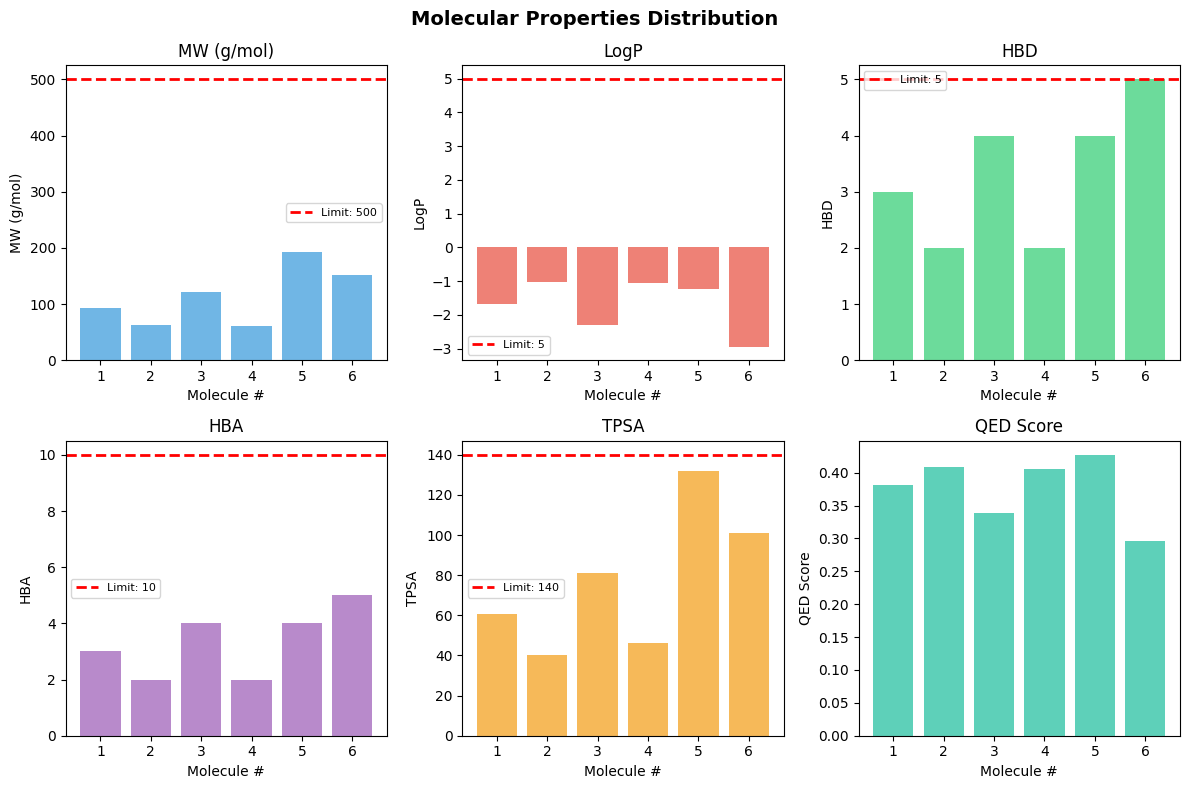


------------------------------------------------------------
 图表说明
------------------------------------------------------------

    MW   - 分子量，红线表示类药性阈值 500
    LogP - 脂水分配系数，红线表示阈值 5
    HBD  - 氢键供体数量，红线表示阈值 5
    HBA  - 氢键受体数量，红线表示阈值 10
    TPSA - 极性表面积，红线表示阈值 140
    QED  - 药物相似性评分 (0-1)

    柱子低于红线 = 符合类药性标准
    



In [ ]:
#@title ## 4.3 性质分布可视化
#@markdown 绘制性质分布图

import matplotlib.pyplot as plt

print("="*60)
print(" 性质分布图")
print("="*60)

if 'df' in dir() and len(df) >= 2:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Molecular Properties Distribution', fontsize=14, fontweight='bold')

    props = [
        ('MW', 'MW (g/mol)', 500),
        ('LogP', 'LogP', 5),
        ('HBD', 'HBD', 5),
        ('HBA', 'HBA', 10),
        ('TPSA', 'TPSA', 140),
        ('QED', 'QED Score', None),
    ]

    colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

    for ax, (col, label, thresh), color in zip(axes.flatten(), props, colors):
        values = df[col].values
        bars = ax.bar(range(len(values)), values, color=color, alpha=0.7)
        if thresh:
            ax.axhline(y=thresh, color='red', linestyle='--', linewidth=2, label=f'Limit: {thresh}')
            ax.legend(fontsize=8)
        ax.set_xlabel('Molecule #')
        ax.set_ylabel(label)
        ax.set_title(label)
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels([str(i+1) for i in range(len(values))])

    plt.tight_layout()
    plt.show()

    # 中文说明
    print("\n" + "-"*60)
    print(" 图表说明")
    print("-"*60)
    print("""
    MW   - 分子量，红线表示类药性阈值 500
    LogP - 脂水分配系数，红线表示阈值 5
    HBD  - 氢键供体数量，红线表示阈值 5
    HBA  - 氢键受体数量，红线表示阈值 10
    TPSA - 极性表面积，红线表示阈值 140
    QED  - 药物相似性评分 (0-1)

    柱子低于红线 = 符合类药性标准
    """)
else:
    print("\n数据不足，跳过可视化")

print("\n" + "="*60)

In [ ]:
#@title ## 4.4 外部验证工具
#@markdown 使用在线工具验证分子性质

print("="*60)
print(" 外部验证工具")
print("="*60)
print("""
将 SMILES 复制到以下网站进行验证：

1. OSIRIS Property Explorer（毒性、药物相似性）
   https://www.organic-chemistry.org/prog/peo/

2. Chemicalize（全面性质预测）
   https://chemicalize.com/

3. SwissADME（药代动力学预测）
   http://www.swissadme.ch/

操作步骤：
1. 从下方复制 SMILES 字符串
2. 粘贴到网站输入框
3. 对比 AI 预测与外部工具结果
""")

if 'generated_smiles' in dir() and generated_smiles:
    print("-"*60)
    print("\n可复制的 SMILES：")
    for i, s in enumerate(generated_smiles, 1):
        print(f"  {i}. {s}")

print("\n" + "="*60)

 外部验证工具

将 SMILES 复制到以下网站进行验证：

1. OSIRIS Property Explorer（毒性、药物相似性）
   https://www.organic-chemistry.org/prog/peo/

2. Chemicalize（全面性质预测）
   https://chemicalize.com/

3. SwissADME（药代动力学预测）
   http://www.swissadme.ch/

操作步骤：
1. 从下方复制 SMILES 字符串
2. 粘贴到网站输入框
3. 对比 AI 预测与外部工具结果

------------------------------------------------------------

可复制的 SMILES：
  1. OCC(O)CO
  2. OCCO
  3. OCC(O)C(O)CO
  4. NCCO
  5. OC(=O)CC(O)(CC(=O)O)C(=O)O
  6. OCC(O)C(O)C(O)CO



---
# 第五部分：自主实验区

 自定义分子分析

输入了 3 个 SMILES

----------------------------------------
分子结构:


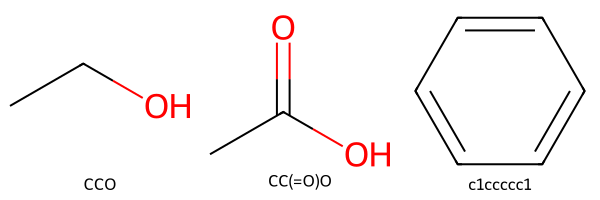


----------------------------------------
性质分析:


,SMILES,MW,LogP,HBD,HBA,TPSA,RotB,QED
0,CCO,46.07,-0.00,1,1,20.23,0,0.407
1,CC(=O)O,60.05,0.09,1,1,37.30,0,0.430
2,c1ccccc1,78.11,1.69,0,0,0.00,0,0.443


In [ ]:
#@title ## 5.1 自定义分子分析
#@markdown 输入你自己的 SMILES 进行分析
#@markdown
#@markdown ### 常用 SMILES 示例
#@markdown | 分子 | SMILES |
#@markdown |------|--------|
#@markdown | 阿司匹林 | CC(=O)OC1=CC=CC=C1C(=O)O |
#@markdown | 咖啡因 | CN1C=NC2=C1C(=O)N(C(=O)N2C)C |
#@markdown | 布洛芬 | CC(C)CC1=CC=C(C=C1)C(C)C(=O)O |
#@markdown
#@markdown ---
#@markdown **输入 SMILES（多个用分号分隔）**
custom_input = "CCO; CC(=O)O; c1ccccc1"  #@param {type:"string"}

print("="*60)
print(" 自定义分子分析")
print("="*60)

smiles_list = [s.strip() for s in custom_input.split(';') if s.strip()]
print(f"\n输入了 {len(smiles_list)} 个 SMILES")

valid_custom = []
for s in smiles_list:
    info = parse_smiles(s)
    if info.get('valid'):
        valid_custom.append(s)
    else:
        print(f"  [无效] {s}")

if valid_custom:
    print("\n" + "-"*40)
    print("分子结构:")
    draw_molecules(valid_custom, mols_per_row=3, size=200)

    print("\n" + "-"*40)
    print("性质分析:")
    df_custom = calc_properties_batch(valid_custom)
    display(df_custom)

print("\n" + "="*60)

In [ ]:
#@title ## 5.2 导出结果
#@markdown 将分析结果保存为 CSV 文件
#@markdown
#@markdown ---
filename = "ai_molecules"  #@param {type:"string"}

from datetime import datetime

print("="*60)
print(" 导出结果")
print("="*60)

if 'df' in dir() and len(df) > 0:
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = f"{filename}_{ts}.csv"
    df.to_csv(filepath, index=False)
    print(f"\n[OK] 已保存: {filepath}")
    print(f"共 {len(df)} 条记录")

    # Colab 下载
    try:
        from google.colab import files
        files.download(filepath)
        print("\n文件已开始下载...")
    except:
        print("\n文件已保存到当前目录")
else:
    print("\n没有数据可导出")

print("\n" + "="*60)

 导出结果

[OK] 已保存: ai_molecules_20260127_110748.csv
共 6 条记录


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


文件已开始下载...



---
#  附录

## A. GT4SD 模型说明

| 模型 | 来源 | 功能 |
|------|------|------|
| T5 | GT4SD/multitask-text-and-chemistry | 文本到分子生成 |
| REINVENT | AstraZeneca | 基于 RNN 的分子生成 |
| Regression Transformer | GT4SD | 性质约束生成 |
| MoLeR | Microsoft | 基于骨架的分子生成 |
| TorchDrug | MIT | 药物发现分子生成 |

---

## B. 本地安装 GT4SD（进阶探索）

如果你想在自己的电脑上运行完整的 GT4SD（包括 REINVENT 等高级模型），可以按以下步骤操作：

### 第一步：安装 Anaconda

下载地址：https://www.anaconda.com/download

### 第二步：打开终端（命令行）

| 系统 | 方法 |
|------|------|
| Windows | 开始菜单 → 搜索 "Anaconda Prompt" |
| Mac | 按 Command+空格 → 输入 "Terminal" |

### 第三步：执行安装命令
```bash
# 1. 克隆 GT4SD 仓库
git clone https://github.com/GT4SD/gt4sd-core.git
cd gt4sd-core

# 2. 创建环境（选择适合你系统的，约需 10-20 分钟）
conda env create -f conda_cpu_mac.yml     # Mac 系统
conda env create -f conda_cpu_linux.yml   # Linux 系统
conda env create -f conda_gpu.yml         # 有 NVIDIA GPU

# 3. 激活环境
conda activate gt4sd

# 4. 安装 GT4SD
pip install gt4sd

# 5. 启动 Jupyter Notebook
jupyter notebook
```

### 第四步：测试代码

在 Jupyter 中运行以下代码测试：
```python
# 测试 REINVENT 模型
from gt4sd.algorithms.conditional_generation.reinvent import ReinventGenerator

config = ReinventGenerator()
generator = config.get_generator()

print("生成分子：")
for i, mol in enumerate(generator):
    print(f"  {i+1}. {mol}")
    if i >= 4:
        break
```
```python
# 测试 Regression Transformer（性质约束生成）
from gt4sd.algorithms.conditional_generation.regression_transformer import (
    RegressionTransformerMolecules
)

config = RegressionTransformerMolecules(algorithm_version="qed")
target = "<QED>0.8</QED>[MASK][MASK][MASK][MASK][MASK]"
generator = config.get_generator(target=target)

print("生成高 QED 分子：")
for i, mol in enumerate(generator):
    print(f"  {i+1}. {mol}")
    if i >= 4:
        break
```

### 常见问题

| 问题 | 解决方法 |
|------|----------|
| git 命令找不到 | 安装 Git: https://git-scm.com/downloads |
| conda 命令找不到 | 使用 Anaconda Prompt 打开 |
| 创建环境很慢 | 正常现象，需下载约 2GB，耐心等待 |
| 模型下载慢 | 首次运行需下载，后续会自动缓存 |
| 清除环境重装 | `conda remove -n gt4sd --all` |

---

## C. 可用模型列表

GT4SD 包含多种分子生成模型，本地安装后可全部使用：

| 模型 | 用途 | Python 代码 |
|------|------|-------------|
| REINVENT | 从头生成新分子 | `ReinventGenerator()` |
| Regression Transformer | 按目标性质生成 | `RegressionTransformerMolecules()` |
| MoLeR | 基于分子骨架生成 | `MoLeRDefaultGenerator()` |
| TorchDrug | 药物发现 | `TorchDrugGraphAF()` |
| MolGPT | 基于 GPT 生成 | `MolGPTGenerator()` |

完整模型列表：https://gt4sd.github.io/gt4sd-core/algorithms.html

---

## D. 在线资源

| 资源 | 链接 |
|------|------|
| GT4SD GitHub | https://github.com/GT4SD/gt4sd-core |
| GT4SD 官方文档 | https://gt4sd.github.io/gt4sd-core/ |
| GT4SD HuggingFace | https://huggingface.co/GT4SD |
| GT4SD 论文 | https://www.nature.com/articles/s41524-023-01028-1 |
| RDKit 文档 | https://www.rdkit.org/docs/ |
| SMILES 教程 | https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html |

---

##  恭喜完成实验！

你已学习了：
- ✓ SMILES 分子表示方法
- ✓ AI 分子生成原理与实践
- ✓ 分子 2D/3D 可视化
- ✓ 物理化学性质计算
- ✓ Lipinski 类药性评估

**想要深入学习？**
- 尝试本地安装 GT4SD，体验更多模型
- 阅读 GT4SD 论文了解算法原理
- 探索不同的分子生成任务

